In [2]:
# Standard Libraries
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

# Add the root directory to sys.path
sys.path.append(os.path.abspath('../..'))

# Importing modules from project
from src.data.make_dataset import create_dataset, create_and_split_dataset
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from src.models.naive_bayes import NaiveBayesModel
from src.utils import set_seed, DEFAULT_SEED
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve


In [3]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=DEFAULT_SEED)
X_train, X_val, X_test, y_train, y_val, y_test = create_and_split_dataset(file_name="processed_data")
X_data, y_data = create_dataset(file_name="processed_data")
enc = OrdinalEncoder()
enc.fit(X_train, y_train)
X_train = enc.transform(X_train)
X_train = pd.DataFrame(X_train, columns=enc.get_feature_names_out())

2025-03-18 19:42:32,725 - INFO - Loading data: processed_data
2025-03-18 19:42:32,783 - INFO - Loading data: processed_data


C:\Users\duyhu\AppData\Roaming\Python\Python312\site-packages\numpy\_core\fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


<Axes: >

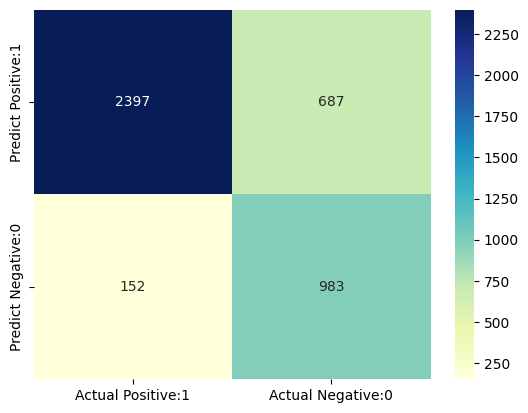

In [4]:
mask = [True]*X_train.shape[1]
nb = NaiveBayesModel(categorical_feature_mask=mask,laplace_smoothing=1)
nb.fit(X_train, y_train)
predict = nb.predict(X_train)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, predict)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

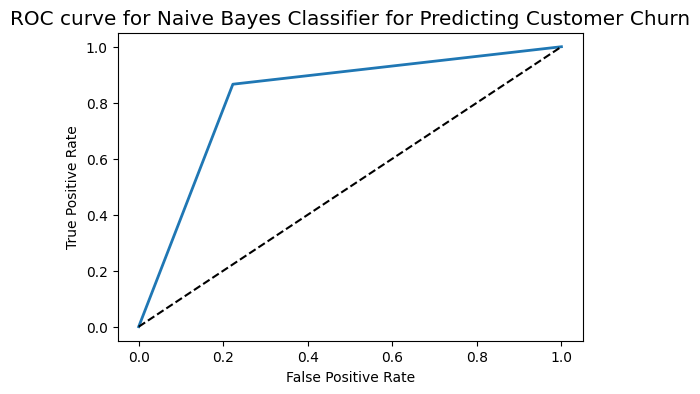

In [5]:
fpr, tpr, _= roc_curve(y_train, predict)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Naive Bayes Classifier for Predicting Customer Churn')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [6]:
ROC_AUC = roc_auc_score(y_train, predict)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.8217


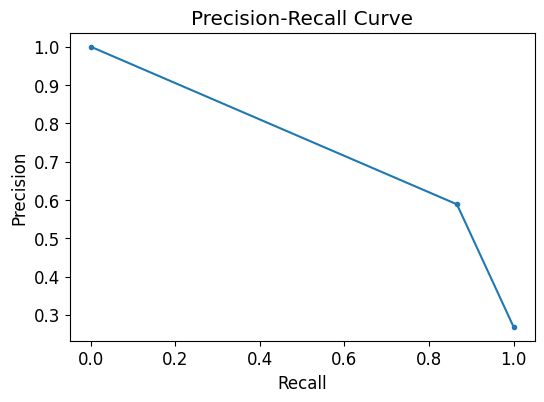

In [7]:
precision, recall, _ = precision_recall_curve(y_train, predict)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [8]:
mask = [True]*X_train.shape[1]
pipeline_nb_own = Pipeline([
    ('m', nb)
])
scores_nb_own = cross_validate(pipeline_nb_own, X_train, y_train,error_score="raise",  scoring=["accuracy","f1_macro","precision_macro","recall_macro"])

C:\Users\duyhu\AppData\Roaming\Python\Python312\site-packages\numpy\_core\fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\duyhu\AppData\Roaming\Python\Python312\site-packages\numpy\_core\fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\duyhu\AppData\Roaming\Python\Python312\site-packages\numpy\_core\fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the

In [9]:
def print_results_table(results_list: list[dict[str, np.ndarray]], headings: list[str]) -> None:
    """
    Print table of sklearn cross-validation scores.
    Makes it easy to compare different models.

    :param results_list: cross-validation outputs of each model
    :param headings: heading that should be displayed for each model
    """
    left_col_size = 25
    other_col_size = 16
    # (name to print, name in dict)
    properties_to_print = [
        ("avg. accuracy:", "test_accuracy"),
        ("avg. f1_macro:", "test_f1_macro"),
        ("avg. precision_macro:", "test_precision_macro"),
        ("avg. recall_macro:", "test_recall_macro"),
        ("avg. fitting time:", "fit_time"),
        ("avg. score time:", "score_time")
    ]

    print(f"{'': <{left_col_size}}", end=" ")
    for heading in headings:
        print(f"{heading: <{other_col_size}}", end=" ")
    print("")

    for prop in properties_to_print:
        print(f"{prop[0]: <{left_col_size}}", end=" ")
        for results in results_list:
            print(f"{results[prop[1]].mean():2.4f}{'': <{other_col_size - 6}}", end=" ")
        print("")


def plot_gridsearch_scores(grid: GridSearchCV,
                           scoring_names: list[str],
                           plot_scores: bool = True,
                           plot_fit_time: bool = True,
                           plot_score_time: bool = True,
                           plot_stds: bool = False,
                           figsize: tuple[float, float] = (20, 5),
                           strip_param_prefix: str = ""
                           ) -> None:

    def remove_prefix(text: str, prefix: str) -> str:
        if text.startswith(prefix):
            return text[len(prefix):]
        return text

    #

    # results from grid search
    results = grid.cv_results_
    mean_fit_time = results["mean_fit_time"]
    std_fit_time = results["std_fit_time"]
    mean_score_time = results["mean_score_time"]
    std_score_time = results["std_score_time"]
    scoring_results = []
    std_score_results = []
    for name in scoring_names:
        scoring_results.append(results['mean_test_' + name])
        std_score_results.append(results['std_test_' + name])

    # setup mask of the best scoring
    masks_names = list(grid.best_params_.keys())
    masks = []  # Save as mask, where each param has best value
    for param_name, best_value in grid.best_params_.items():
        masks.append(results["param_" + param_name].data == best_value)
    params = grid.param_grid

    # plotting Scores
    if plot_scores:
        if len(masks_names) == 1:
            fig, ax = plt.subplots(figsize=figsize)
            fig.suptitle('Score per Parameter')
            fig.text(0.04, 0.5, 'Mean Score', va='center', rotation='vertical')
            p = masks_names[0]
            x = [str(item) for item in params[p]]
            for j, scoring_name in enumerate(scoring_names):
                y = scoring_results[j]
                e = std_score_results[j]
                if plot_stds:
                    ax.errorbar(x, y, yerr=e, linestyle='--', marker='o', label=scoring_name, barsabove=True, capsize=5)
                else:
                    ax.errorbar(x, y, linestyle='--', marker='o', label=scoring_name)
            ax.set_xlabel(remove_prefix(p, strip_param_prefix).upper())
            plt.legend()
            plt.show()
        if len(masks_names) > 1:
            fig, ax = plt.subplots(1, len(params), sharex='none', sharey='all', figsize=figsize)
            fig.suptitle('Score per Parameter')
            fig.text(0.04, 0.5, 'Mean Score', va='center', rotation='vertical')
            for i, p in enumerate(masks_names):
                # find the best indices, for the given parameter
                # e.g. if param-1 has values 1,2,3; find the indices where they reach the best values
                m = np.stack(masks[:i] + masks[i + 1:])
                best_parms_mask = m.all(axis=0)
                best_indices = np.where(best_parms_mask)
                # plot
                # convert x to string, so that values are equally spaced in plot
                x = [str(item) for item in params[p]]
                for j, scoring_name in enumerate(scoring_names):
                    y = scoring_results[j][best_indices]
                    e = std_score_results[j][best_indices]
                    if plot_stds:
                        ax[i].errorbar(x, y, yerr=e, linestyle='--', marker='o', label=scoring_name, barsabove=True,
                                       capsize=5)
                    else:
                        ax[i].errorbar(x, y, linestyle='--', marker='o', label=scoring_name)
                ax[i].set_xlabel(remove_prefix(p, strip_param_prefix).upper())
            plt.legend()
            plt.show()

    # plotting fitting time
    if plot_fit_time:
        if len(masks_names) == 1:
            fig, ax = plt.subplots(figsize=figsize)
            fig.suptitle('Fitting Time per Parameter')
            fig.text(0.04, 0.5, 'Mean Fitting Time', va='center', rotation='vertical')
            p = masks_names[0]
            x = [str(item) for item in params[p]]
            y = mean_fit_time
            e = std_fit_time
            if plot_stds:
                ax.errorbar(x, y, yerr=e, linestyle='--', marker='o', color="#9467bd", barsabove=True, capsize=5)
            else:
                ax.errorbar(x, y, linestyle='--', marker='o', color="#9467bd")
            ax.set_xlabel(remove_prefix(p, strip_param_prefix).upper())
            plt.show()
        if len(masks_names) > 1:
            fig, ax = plt.subplots(1, len(params), sharex='none', sharey='all', figsize=figsize)
            fig.suptitle('Fitting Time per Parameter')
            fig.text(0.04, 0.5, 'Mean Fitting Time', va='center', rotation='vertical')
            for i, p in enumerate(masks_names):
                # find best indices
                m = np.stack(masks[:i] + masks[i + 1:])
                best_parms_mask = m.all(axis=0)
                best_indices = np.where(best_parms_mask)
                # plot
                x = [str(item) for item in params[p]]
                y = mean_fit_time[best_indices]
                e = std_fit_time[best_indices]
                if plot_stds:
                    ax[i].errorbar(x, y, yerr=e, linestyle='--', marker='o', color="#9467bd", barsabove=True, capsize=5)
                else:
                    ax[i].errorbar(x, y, linestyle='--', marker='o', color="#9467bd")
                ax[i].set_xlabel(remove_prefix(p, strip_param_prefix).upper())
            plt.show()

    # plotting score time
    if plot_score_time:
        if len(masks_names) == 1:
            fig, ax = plt.subplots(figsize=figsize)
            fig.suptitle('Score Time per Parameter')
            fig.text(0.04, 0.5, 'Mean Score Time', va='center', rotation='vertical')
            p = masks_names[0]
            x = [str(item) for item in params[p]]
            y = mean_score_time
            e = std_score_time
            if plot_stds:
                ax.errorbar(x, y, yerr=e, linestyle='--', marker='o', color="#9467bd", barsabove=True, capsize=5)
            else:
                ax.errorbar(x, y, linestyle='--', marker='o', color="#9467bd")
            ax.set_xlabel(remove_prefix(p, strip_param_prefix).upper())
            plt.show()
        if len(masks_names) > 1:
            fig, ax = plt.subplots(1, len(params), sharex='none', sharey='all', figsize=figsize)
            fig.suptitle('Score Time per Parameter')
            fig.text(0.04, 0.5, 'Mean Score Time', va='center', rotation='vertical')
            for i, p in enumerate(masks_names):
                # find best indices
                m = np.stack(masks[:i] + masks[i + 1:])
                best_parms_mask = m.all(axis=0)
                best_indices = np.where(best_parms_mask)
                # plot
                x = [str(item) for item in params[p]]
                y = mean_score_time[best_indices]
                e = std_score_time[best_indices]
                if plot_stds:
                    ax[i].errorbar(x, y, yerr=e, linestyle='--', marker='o', color="#9467bd", barsabove=True, capsize=5)
                else:
                    ax[i].errorbar(x, y, linestyle='--', marker='o', color="#9467bd")
                ax[i].set_xlabel(remove_prefix(p, strip_param_prefix).upper())
            plt.show()

In [10]:
print_results_table([scores_nb_own], headings=["our_nb"])

                          our_nb           
avg. accuracy:            0.7691           
avg. f1_macro:            0.7306           
avg. precision_macro:     0.7203           
avg. recall_macro:        0.7576           
avg. fitting time:        0.2117           
avg. score time:          0.3996           


In [11]:
mask = [True]*X_train.shape[1]
pipe = Pipeline([
    ('m', NaiveBayesModel(categorical_feature_mask=mask))
])
parameters = {
    "m__laplace_smoothing": [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 8, 9, 10, 15, 20, 25, 50, 100, 200]
}
grid = GridSearchCV(pipe, parameters,cv=kfold, scoring=["accuracy", "f1_macro", "precision_macro", "recall_macro"], refit="accuracy")
grid.fit(X_train, y_train)

C:\Users\duyhu\AppData\Roaming\Python\Python312\site-packages\numpy\_core\fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\duyhu\AppData\Roaming\Python\Python312\site-packages\numpy\_core\fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\duyhu\AppData\Roaming\Python\Python312\site-packages\numpy\_core\fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('m',
                                        NaiveBayesModel(categorical_feature_mask=[True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True,
                                                                                  True]))]),
             param_grid={'m__laplace_smoothing': [0.5, 1, 1.5, 2, 2.5, 3, 3.5,
                                                  4, 4.5, 5, 5.5, 6, 6.5, 7, 8,
                                                  9, 10, 15, 20, 25, 50, 100,
                                                  200]},
             refit='accuracy',
             scoring=['accuracy', 'f1_macro', 'precision_macro',
                      'recall_macro'])

In [12]:
print("Best Params (our naive bayes): "  + str(grid.best_params_))

Best Params (our naive bayes): {'m__laplace_smoothing': 8}


2025-03-18 19:44:18,100 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-18 19:44:18,100 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-18 19:44:18,105 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-18 19:44:18,109 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-03-18 19:44:18,111 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


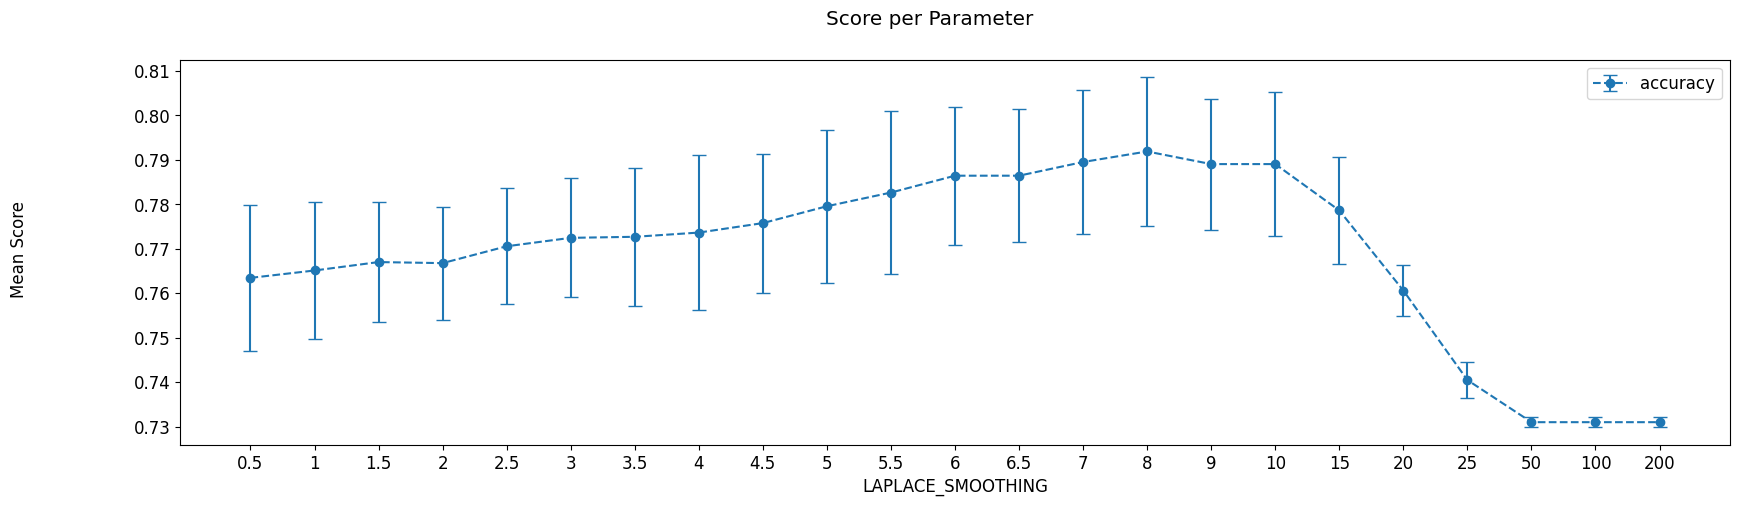

2025-03-18 19:44:18,331 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-18 19:44:18,331 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-18 19:44:18,331 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-18 19:44:18,338 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-18 19:44:18,338 - INFO - Using categorical units to plot a list of strings that are all parsable as 

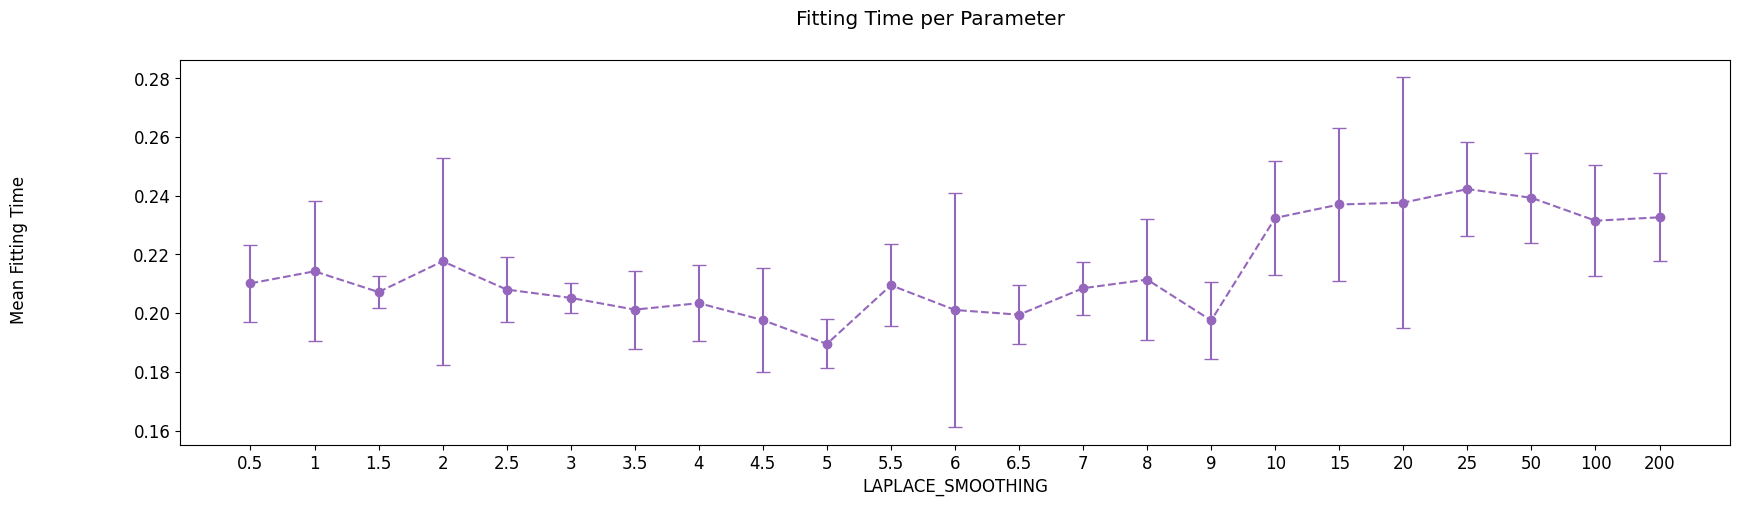

2025-03-18 19:44:18,501 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-18 19:44:18,501 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-18 19:44:18,514 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-18 19:44:18,514 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-18 19:44:18,514 - INFO - Using categorical units to plot a list of strings that are all parsable as 

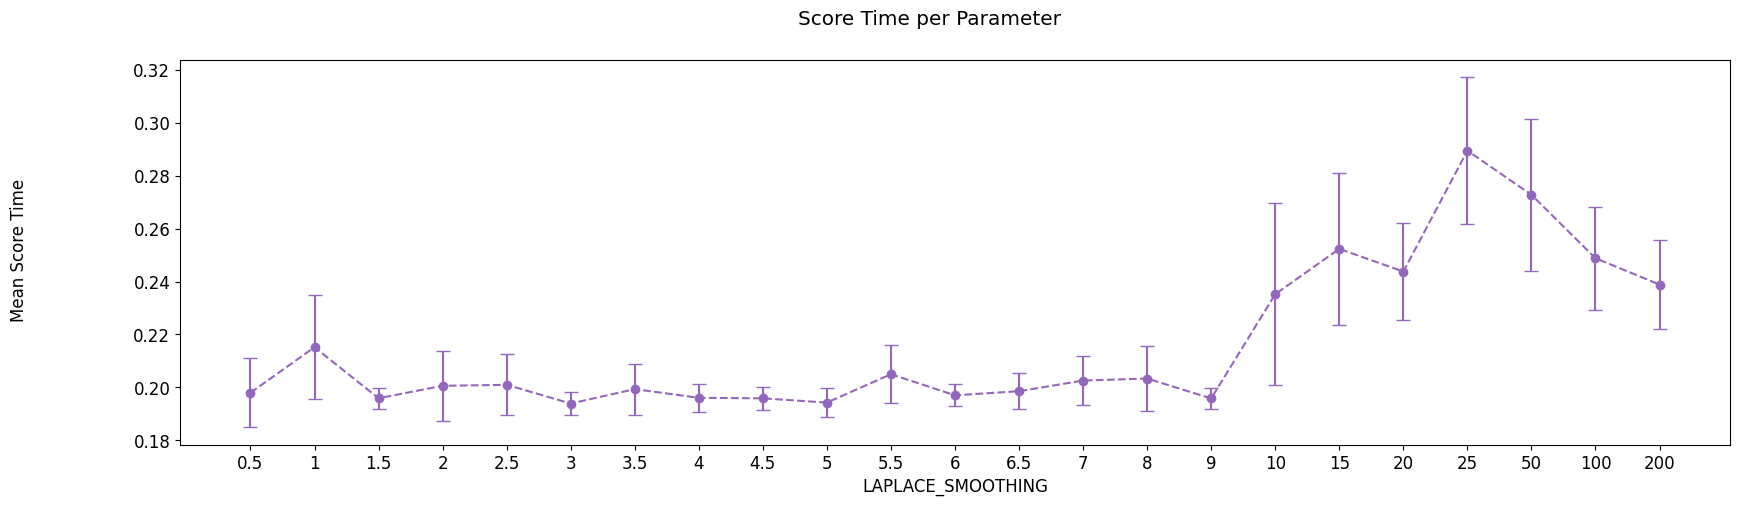

In [13]:
plot_gridsearch_scores(grid, ["accuracy"], strip_param_prefix="m__", plot_stds=True)

C:\Users\duyhu\AppData\Roaming\Python\Python312\site-packages\numpy\_core\fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


<Axes: >

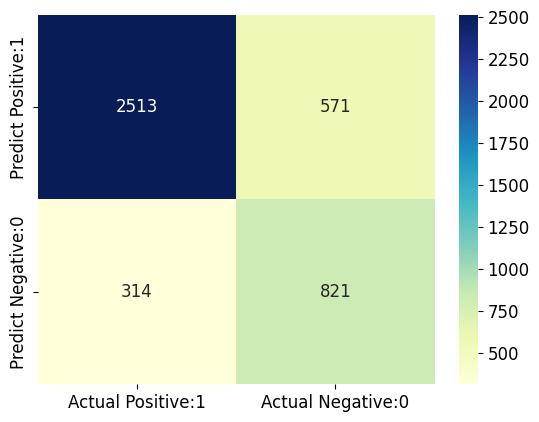

In [14]:
nb = NaiveBayesModel(categorical_feature_mask=mask,laplace_smoothing=8)
nb.fit(X_train, y_train)
predict = nb.predict(X_train)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, predict)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

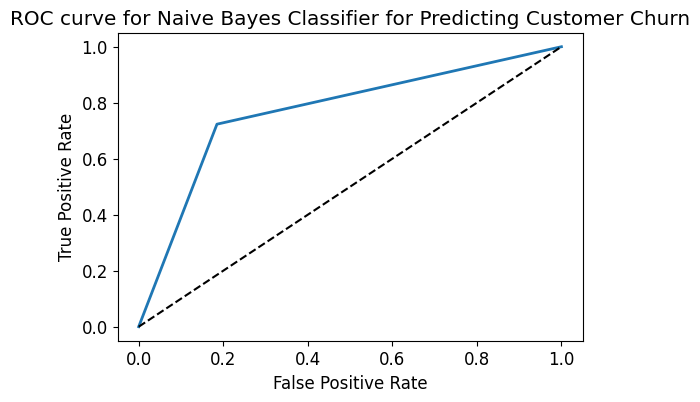

In [15]:
fpr, tpr, thresholds= roc_curve(y_train, predict)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Naive Bayes Classifier for Predicting Customer Churn')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [16]:
ROC_AUC = roc_auc_score(y_train, predict)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.7691


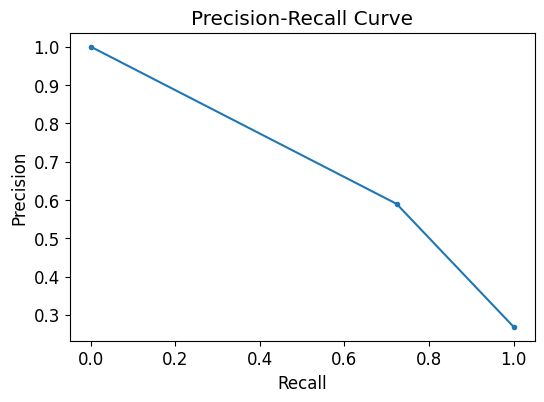

In [17]:
precision, recall, _ = precision_recall_curve(y_train, predict)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [18]:
mask = [True]*X_train.shape[1]
pipeline_nb_own = Pipeline([
    ('m', nb)
])
scores_nb_own = cross_validate(pipeline_nb_own, X_train, y_train,error_score="raise",  scoring=["accuracy","f1_macro","precision_macro","recall_macro"])

C:\Users\duyhu\AppData\Roaming\Python\Python312\site-packages\numpy\_core\fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\duyhu\AppData\Roaming\Python\Python312\site-packages\numpy\_core\fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\duyhu\AppData\Roaming\Python\Python312\site-packages\numpy\_core\fromnumeric.py:4006: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the

In [19]:
print_results_table([scores_nb_own], headings=["our_nb"])

                          our_nb           
avg. accuracy:            0.7924           
avg. f1_macro:            0.7224           
avg. precision_macro:     0.7360           
avg. recall_macro:        0.7139           
avg. fitting time:        0.2094           
avg. score time:          0.4762           


In [20]:
pipeline_nb = Pipeline([
    ('m', CategoricalNB(min_categories=X_train.nunique(), alpha=50))
])
scores_nb = cross_validate(pipeline_nb, X_train, y_train, error_score="raise",  scoring=["accuracy","f1_macro","precision_macro","recall_macro"])

In [21]:
pipeline_rf = Pipeline([
    ('m', RandomForestClassifier(random_state=DEFAULT_SEED))
])
scores_rf = cross_validate(pipeline_rf, X_train, y_train,error_score="raise",  scoring=["accuracy","f1_macro","precision_macro","recall_macro"])

In [22]:
print_results_table([scores_nb_own, scores_nb, scores_rf], headings=["our_nb", "sklearn_nb", "sklearn_rf"])

                          our_nb           sklearn_nb       sklearn_rf       
avg. accuracy:            0.7924           0.7608           0.7943           
avg. f1_macro:            0.7224           0.7221           0.7183           
avg. precision_macro:     0.7360           0.7124           0.7424           
avg. recall_macro:        0.7139           0.7482           0.7045           
avg. fitting time:        0.2094           0.0096           0.5504           
avg. score time:          0.4762           0.0092           0.0306           
